# Exploring CGM Data

In [3]:
import pandas as pd


# Specify the file path for the .xlsl file
df = pd.read_excel('/Users/bg.lim/Downloads/Texas A&M_Agrilife/Projects/1.CGM/Pilot/Datas/Preprocessing/all_cgm.xlsx', engine='openpyxl')  # 파일 경로 지정


# Display the dataframe
df

,StudyID,Timestamp,Glucose mg/dL
0,1,2022-10-06 01:34:00,78
1,1,2022-10-06 01:49:00,76
2,1,2022-10-06 02:04:00,78
3,1,2022-10-06 02:19:00,75
4,1,2022-10-06 02:34:00,75
...,...,...,...
71712,89,2023-05-09 19:08:00,114
71713,89,2023-05-09 19:23:00,136
71714,89,2023-05-09 19:38:00,142
71715,89,2023-05-09 19:53:00,137


## Number of Data Points and Average per Participant (969.15)

In [42]:
# Calculate the average number of rows per StudyID
average_rows_per_studyid = studyid_counts_sorted.mean()

# Print the average
print("\nAverage Number of Rows per StudyID:", round(average_rows_per_studyid, 2))

# Count the number of rows per StudyID
studyid_counts = df['StudyID'].value_counts()
# Sort StudyID in ascending order
studyid_counts_sorted = studyid_counts.sort_index()

# Print sorted results
print("\nNumber of Rows per StudyID (Sorted by StudyID):\n", studyid_counts_sorted)


Average Number of Rows per StudyID: 969.15

Number of Rows per StudyID (Sorted by StudyID):
 StudyID
1      829
2      864
3      288
7     1246
8     1248
      ... 
84    1248
85    1153
86    1248
87    1247
89    1248
Name: count, Length: 74, dtype: int64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   StudyID        71717 non-null  int64         
 1   Timestamp      71717 non-null  datetime64[ns]
 2   Glucose mg/dL  71717 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.6 MB


# Plotting Glucose from random 5 participants

# Daily Average of Glucose level

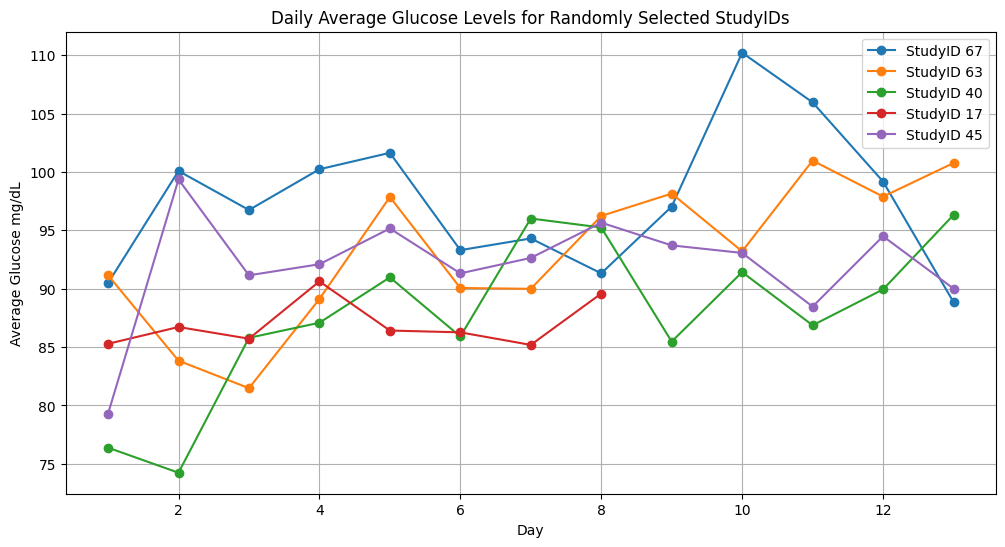

In [9]:


# Convert Timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Function to calculate "Day X" for each StudyID
def assign_day_numbers(df):
    df = df.sort_values(by=['StudyID', 'Timestamp'])  # Sort by StudyID and time
    df['Day'] = df.groupby('StudyID')['Timestamp'].transform(
        lambda x: (x - x.min()).dt.days + 1  # Calculate days from first record
    )
    return df

# Apply function to assign day numbers
df = assign_day_numbers(df)

# Randomly select 5 StudyIDs
random_study_ids = np.random.choice(df['StudyID'].unique(), 5, replace=False)

# Compute daily average glucose levels for each StudyID
daily_avg_df = df.groupby(['StudyID', 'Day'])['Glucose mg/dL'].mean().reset_index()

# Filter data for selected StudyIDs
filtered_daily_avg_df = daily_avg_df[daily_avg_df['StudyID'].isin(random_study_ids)]

# Plot the daily average glucose levels
plt.figure(figsize=(12, 6))

for study_id in random_study_ids:
    study_data = filtered_daily_avg_df[filtered_daily_avg_df['StudyID'] == study_id]
    plt.plot(study_data['Day'], study_data['Glucose mg/dL'], marker='o', linestyle='-', label=f'StudyID {study_id}')

# Graph settings
plt.xlabel('Day')
plt.ylabel('Average Glucose mg/dL')
plt.title('Daily Average Glucose Levels for Randomly Selected StudyIDs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# Ramdom 5 participants, 1 day (24H), Glucose changes + GE counts

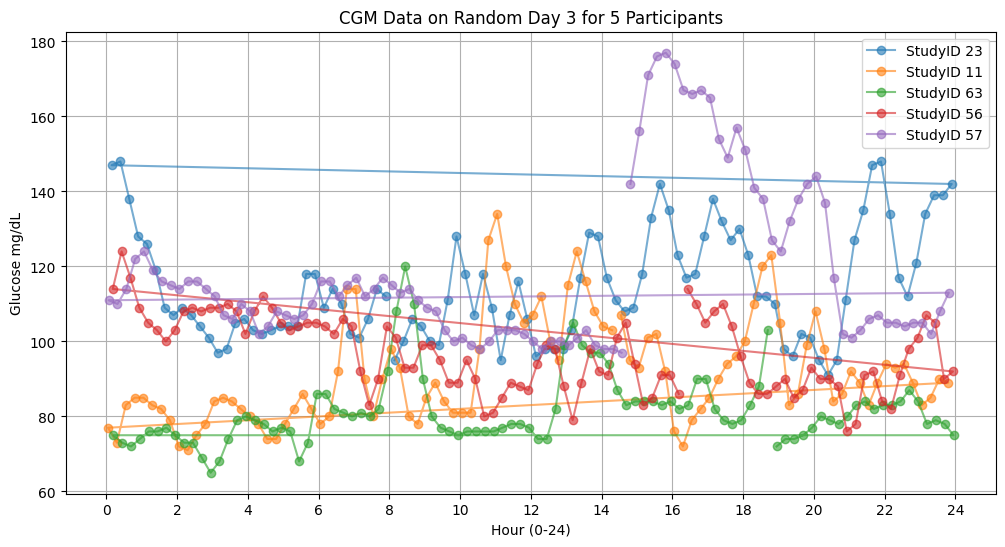

   StudyID  CGM Mean    1SD (GE)  1.5SD (GE)
0       23    114.44  14.62 (17)  21.93 (10)
1       11     91.81  14.01 (17)  21.01 (10)
2       63     81.48   9.25 (11)   13.88 (9)
3       56     96.84  10.06 (19)   15.09 (5)
4       57    118.23  21.35 (17)  32.03 (12)


In [18]:


# Convert Timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Function to assign "Day X" for each StudyID
def assign_day_numbers(df):
    df = df.sort_values(by=['StudyID', 'Timestamp'])  # Sort data by StudyID and time
    df['Day'] = df.groupby('StudyID')['Timestamp'].transform(
        lambda x: (x - x.min()).dt.days + 1  # Compute days from first measurement
    )
    return df

# Apply function to assign day numbers
df = assign_day_numbers(df)

# Select a random day (Day X)
random_day = random.choice(df['Day'].unique())

# Select 5 random StudyIDs
random_study_ids = np.random.choice(df['StudyID'].unique(), 5, replace=False)

# Filter data for the selected day and participants
selected_day_df = df[(df['Day'] == random_day) & (df['StudyID'].isin(random_study_ids))].copy()

# Extract hour as a continuous variable (0-24 hours)
selected_day_df['Hour'] = selected_day_df['Timestamp'].dt.hour + selected_day_df['Timestamp'].dt.minute / 60

# Initialize list to store summary statistics
summary_data = []

# Create the plot
plt.figure(figsize=(12, 6))

# Plot individual participant data with light lines and markers
for study_id in random_study_ids:
    study_data = selected_day_df[selected_day_df['StudyID'] == study_id]
    
    # Compute individual mean and standard deviations
    mean_glucose = study_data['Glucose mg/dL'].mean()
    std_1 = study_data['Glucose mg/dL'].std()  # 1 standard deviation
    std_1_5 = std_1 * 1.5  # 1.5 standard deviations

    # Count glucose excursions (GE) above 1SD and 1.5SD
    ge_1sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1)).sum()
    ge_1_5sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1_5)).sum()

    # Append to summary table
    summary_data.append([study_id, round(mean_glucose, 2), f"{round(std_1, 2)} ({ge_1sd})", f"{round(std_1_5, 2)} ({ge_1_5sd})"])

    # Plot individual participant data
    plt.plot(study_data['Hour'], study_data['Glucose mg/dL'], marker='o', linestyle='-', alpha=0.6, label=f'StudyID {study_id}')

# Configure the plot
plt.xlabel('Hour (0-24)')
plt.ylabel('Glucose mg/dL')
plt.title(f'CGM Data on Random Day {random_day} for 5 Participants')
plt.legend()
plt.xticks(np.arange(0, 25, 2))  # Set x-axis labels at every 2 hours
plt.grid(True)

# Display the plot
plt.show()

# Create a summary table
summary_df = pd.DataFrame(summary_data, columns=['StudyID', 'CGM Mean', '1SD (GE)', '1.5SD (GE)'])

# Display summary table
print(summary_df)


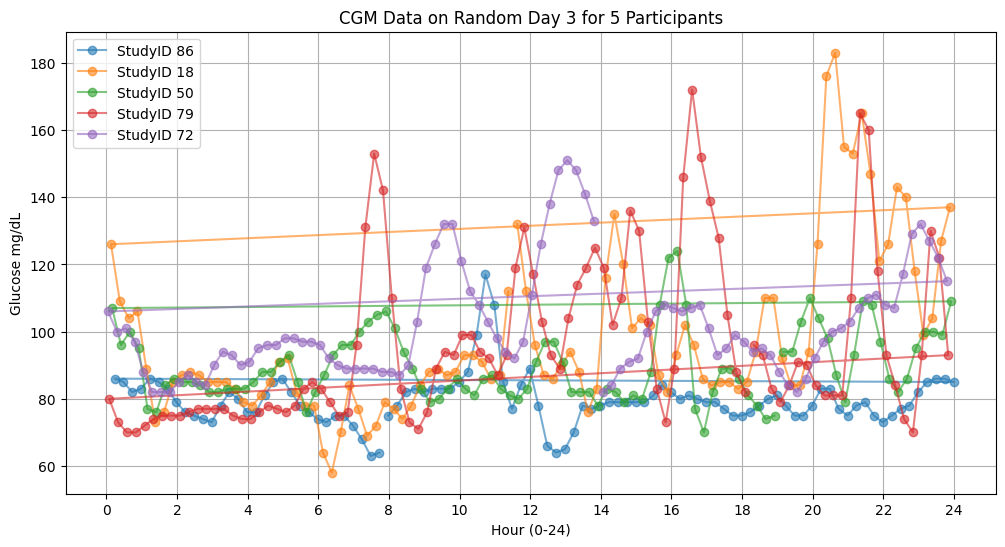

   StudyID  CGM Mean    1SD (GE)  1.5SD (GE)
0       86     79.52    7.49 (5)   11.24 (3)
1       18     97.81   24.4 (15)   36.6 (10)
2       50     89.69  10.68 (15)  16.02 (10)
3       79     96.23  24.51 (16)   36.76 (9)
4       72    102.07  16.45 (16)  24.67 (11)


In [21]:

# Convert Timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Function to assign "Day X" for each StudyID
def assign_day_numbers(df):
    df = df.sort_values(by=['StudyID', 'Timestamp'])  # Sort data by StudyID and time
    df['Day'] = df.groupby('StudyID')['Timestamp'].transform(
        lambda x: (x - x.min()).dt.days + 1  # Compute days from first measurement
    )
    return df

# Apply function to assign day numbers
df = assign_day_numbers(df)

# Select a random day (Day X)
random_day = random.choice(df['Day'].unique())

# Select 5 random StudyIDs
random_study_ids = np.random.choice(df['StudyID'].unique(), 5, replace=False)

# Filter data for the selected day and participants
selected_day_df = df[(df['Day'] == random_day) & (df['StudyID'].isin(random_study_ids))].copy()

# Extract hour as a continuous variable (0-24 hours)
selected_day_df['Hour'] = selected_day_df['Timestamp'].dt.hour + selected_day_df['Timestamp'].dt.minute / 60

# Initialize list to store summary statistics
summary_data = []

# Create the plot
plt.figure(figsize=(12, 6))

# Plot individual participant data with light lines and markers
for study_id in random_study_ids:
    study_data = selected_day_df[selected_day_df['StudyID'] == study_id]
    
    # Compute individual mean and standard deviations
    mean_glucose = study_data['Glucose mg/dL'].mean()
    std_1 = study_data['Glucose mg/dL'].std()  # 1 standard deviation
    std_1_5 = std_1 * 1.5  # 1.5 standard deviations

    # Count glucose excursions (GE) above 1SD and 1.5SD
    ge_1sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1)).sum()
    ge_1_5sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1_5)).sum()

    # Append to summary table
    summary_data.append([study_id, round(mean_glucose, 2), f"{round(std_1, 2)} ({ge_1sd})", f"{round(std_1_5, 2)} ({ge_1_5sd})"])

    # Plot individual participant data
    plt.plot(study_data['Hour'], study_data['Glucose mg/dL'], marker='o', linestyle='-', alpha=0.6, label=f'StudyID {study_id}')

# Configure the plot
plt.xlabel('Hour (0-24)')
plt.ylabel('Glucose mg/dL')
plt.title(f'CGM Data on Random Day {random_day} for 5 Participants')
plt.legend()
plt.xticks(np.arange(0, 25, 2))  # Set x-axis labels at every 2 hours
plt.grid(True)

# Display the plot
plt.show()

# Create a summary table
summary_df = pd.DataFrame(summary_data, columns=['StudyID', 'CGM Mean', '1SD (GE)', '1.5SD (GE)'])

# Display summary table
print(summary_df)


# Ramdom 2 day (48H), Glucose changes + GE counts

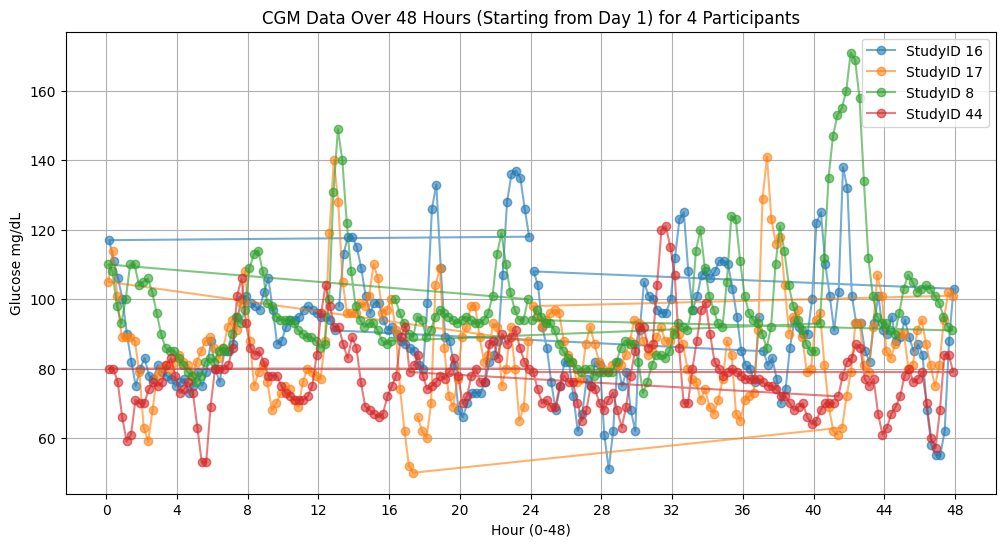


CGM Summary Data (48 Hours)

   StudyID  CGM Mean    1SD  1SD GE  1.5SD  1.5SD GE
0       16     91.49  16.94      27  25.41        17
1       17     86.00  14.45      23  21.68        12
2        8     97.86  17.11      18  25.67        13
3       44     77.91  10.68      24  16.03        12

Summary table saved as 'cgm_summary_48_hours.csv'


In [28]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select a random starting day (Day X)
random_start_day = random.choice(df['Day'].unique())

# Select 4 random StudyIDs
random_study_ids = np.random.choice(df['StudyID'].unique(), 4, replace=False)

# Filter data for the selected 48-hour period and participants
selected_day_df = df[
    (df['Day'] >= random_start_day) & 
    (df['Day'] < random_start_day + 2) &  # Include 48-hour window
    (df['StudyID'].isin(random_study_ids))
].copy()

# Convert timestamps to hours in a 48-hour period
selected_day_df['Hour'] = (selected_day_df['Day'] - random_start_day) * 24 + \
                          selected_day_df['Timestamp'].dt.hour + \
                          selected_day_df['Timestamp'].dt.minute / 60

# Initialize list to store summary statistics
summary_data = []

# Create the plot
plt.figure(figsize=(12, 6))

# Plot individual participant data with light lines and markers
for study_id in random_study_ids:
    study_data = selected_day_df[selected_day_df['StudyID'] == study_id]
    
    # Compute individual mean and standard deviations
    mean_glucose = study_data['Glucose mg/dL'].mean()
    std_1 = study_data['Glucose mg/dL'].std()  # 1 standard deviation
    std_1_5 = std_1 * 1.5  # 1.5 standard deviations

    # Count glucose excursions (GE) above 1SD and 1.5SD
    ge_1sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1)).sum()
    ge_1_5sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1_5)).sum()

    # Append to summary table
    summary_data.append([study_id, round(mean_glucose, 2), round(std_1, 2), ge_1sd, round(std_1_5, 2), ge_1_5sd])

    # Plot individual participant data
    plt.plot(study_data['Hour'], study_data['Glucose mg/dL'], marker='o', linestyle='-', alpha=0.6, label=f'StudyID {study_id}')

# Configure the plot
plt.xlabel('Hour (0-48)')
plt.ylabel('Glucose mg/dL')
plt.title(f'CGM Data Over 48 Hours (Starting from Day {random_start_day}) for 4 Participants')
plt.legend()
plt.xticks(np.arange(0, 49, 4))  # Set x-axis labels at every 4 hours
plt.grid(True)

# Display the plot
plt.show()

# Create a summary table
summary_df = pd.DataFrame(summary_data, columns=['StudyID', 'CGM Mean', '1SD', '1SD GE', '1.5SD', '1.5SD GE'])

# Print summary table
print("\nCGM Summary Data (48 Hours)\n")
print(summary_df)

# Save summary table to CSV file
summary_df.to_csv("cgm_summary_48_hours.csv", index=False)
print("\nSummary table saved as 'cgm_summary_48_hours.csv'")


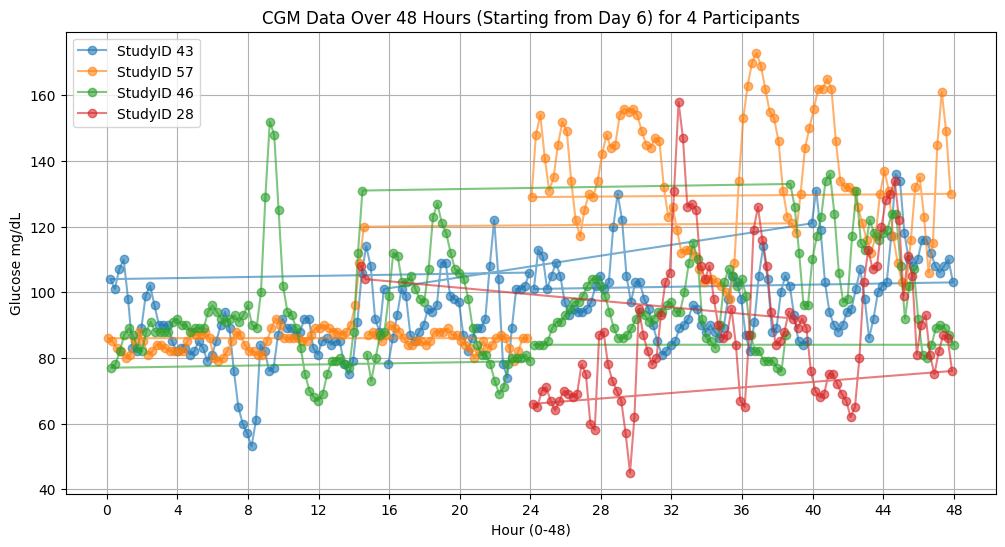


CGM Summary Data (48 Hours)

   StudyID  CGM Mean    1SD (GE)  1.5SD (GE)
0       43     94.81  13.24 (25)  19.86 (13)
1       57    109.90  27.81 (40)  41.72 (21)
2       46     95.54  15.81 (32)  23.72 (18)
3       28     89.06  22.13 (15)  33.19 (10)


In [30]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select a random starting day (Day X)
random_start_day = random.choice(df['Day'].unique())

# Select 4 random StudyIDs
random_study_ids = np.random.choice(df['StudyID'].unique(), 4, replace=False)

# Filter data for the selected 48-hour period and participants
selected_day_df = df[
    (df['Day'] >= random_start_day) & 
    (df['Day'] < random_start_day + 2) &  # Include 48-hour window
    (df['StudyID'].isin(random_study_ids))
].copy()

# Convert timestamps to hours in a 48-hour period
selected_day_df['Hour'] = (selected_day_df['Day'] - random_start_day) * 24 + \
                          selected_day_df['Timestamp'].dt.hour + \
                          selected_day_df['Timestamp'].dt.minute / 60

# Initialize list to store summary statistics
summary_data = []

# Create the plot
plt.figure(figsize=(12, 6))

# Plot individual participant data with light lines and markers
for study_id in random_study_ids:
    study_data = selected_day_df[selected_day_df['StudyID'] == study_id]
    
    # Compute individual mean and standard deviations
    mean_glucose = study_data['Glucose mg/dL'].mean()
    std_1 = study_data['Glucose mg/dL'].std()  # 1 standard deviation
    std_1_5 = std_1 * 1.5  # 1.5 standard deviations

    # Count glucose excursions (GE) above 1SD and 1.5SD
    ge_1sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1)).sum()
    ge_1_5sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1_5)).sum()

    # Append to summary table with GE in parentheses
    summary_data.append([study_id, round(mean_glucose, 2), f"{round(std_1, 2)} ({ge_1sd})", f"{round(std_1_5, 2)} ({ge_1_5sd})"])

    # Plot individual participant data
    plt.plot(study_data['Hour'], study_data['Glucose mg/dL'], marker='o', linestyle='-', alpha=0.6, label=f'StudyID {study_id}')

# Configure the plot
plt.xlabel('Hour (0-48)')
plt.ylabel('Glucose mg/dL')
plt.title(f'CGM Data Over 48 Hours (Starting from Day {random_start_day}) for 4 Participants')
plt.legend()
plt.xticks(np.arange(0, 49, 4))  # Set x-axis labels at every 4 hours
plt.grid(True)

# Display the plot
plt.show()

# Create a summary table
summary_df = pd.DataFrame(summary_data, columns=['StudyID', 'CGM Mean', '1SD (GE)', '1.5SD (GE)'])

# Print summary table
print("\nCGM Summary Data (48 Hours)\n")
print(summary_df)




# Random 48H, 2 participants with GE counts

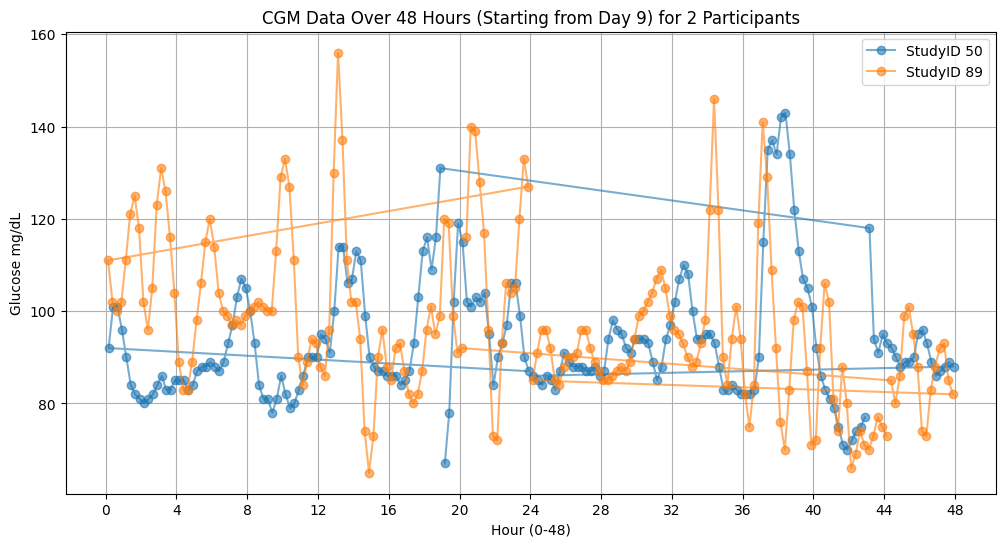


CGM Summary Data (48 Hours)

   StudyID  CGM Mean    1SD (GE)  1.5SD (GE)
0       50      93.3  13.23 (27)  19.84 (16)
1       89      97.1  16.95 (31)  25.42 (18)


In [32]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select a random starting day (Day X)
random_start_day = random.choice(df['Day'].unique())

# Select 2 random StudyIDs
random_study_ids = np.random.choice(df['StudyID'].unique(), 2, replace=False)

# Filter data for the selected 48-hour period and participants
selected_day_df = df[
    (df['Day'] >= random_start_day) & 
    (df['Day'] < random_start_day + 2) &  # Include 48-hour window
    (df['StudyID'].isin(random_study_ids))
].copy()

# Convert timestamps to hours in a 48-hour period
selected_day_df['Hour'] = (selected_day_df['Day'] - random_start_day) * 24 + \
                          selected_day_df['Timestamp'].dt.hour + \
                          selected_day_df['Timestamp'].dt.minute / 60

# Initialize list to store summary statistics
summary_data = []

# Create the plot
plt.figure(figsize=(12, 6))

# Plot individual participant data with light lines and markers
for study_id in random_study_ids:
    study_data = selected_day_df[selected_day_df['StudyID'] == study_id]
    
    # Compute individual mean and standard deviations
    mean_glucose = study_data['Glucose mg/dL'].mean()
    std_1 = study_data['Glucose mg/dL'].std()  # 1 standard deviation
    std_1_5 = std_1 * 1.5  # 1.5 standard deviations

    # Count glucose excursions (GE) above 1SD and 1.5SD
    ge_1sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1)).sum()
    ge_1_5sd = (study_data['Glucose mg/dL'] > (mean_glucose + std_1_5)).sum()

    # Append to summary table with GE in parentheses
    summary_data.append([study_id, round(mean_glucose, 2), f"{round(std_1, 2)} ({ge_1sd})", f"{round(std_1_5, 2)} ({ge_1_5sd})"])

    # Plot individual participant data
    plt.plot(study_data['Hour'], study_data['Glucose mg/dL'], marker='o', linestyle='-', alpha=0.6, label=f'StudyID {study_id}')

# Configure the plot
plt.xlabel('Hour (0-48)')
plt.ylabel('Glucose mg/dL')
plt.title(f'CGM Data Over 48 Hours (Starting from Day {random_start_day}) for 2 Participants')
plt.legend()
plt.xticks(np.arange(0, 49, 4))  # Set x-axis labels at every 4 hours
plt.grid(True)

# Display the plot
plt.show()

# Create a summary table
summary_df = pd.DataFrame(summary_data, columns=['StudyID', 'CGM Mean', '1SD (GE)', '1.5SD (GE)'])

# Print summary table
print("\nCGM Summary Data (48 Hours)\n")
print(summary_df)




# Daily Average dataset
## The existing daily average dataset reports significantly fewer Glucose Excursions (GE).

In [38]:
import pandas as pd


# Specify the file path for the .xlsl file
df_daily = pd.read_excel('/Users/bg.lim/Downloads/Texas A&M_Agrilife/Projects/1.CGM/Pilot/Datas/CGM/CGM_Daily Averages.xlsx', engine='openpyxl')  # 파일 경로 지정


# Display the dataframe
df_daily

,Study ID,ID,Study Day,Date,Daily Avg Glucose,Daily SD,Mean+1SD,Average Loneliness Score,Daily Sum GE
0,1,60644,0,2023-10-05,81.266667,10.037204,91.303870,NaN,3.0
1,1,60644,1,2023-10-06,87.135417,11.002028,98.137445,1.0,3.0
2,1,60644,2,2023-10-07,66.906250,9.818434,76.724684,1.0,4.0
3,1,60644,3,2023-10-08,72.718750,14.460620,87.179370,1.0,3.0
4,1,60644,4,2023-10-09,70.177083,7.335558,77.512642,1.0,5.0
...,...,...,...,...,...,...,...,...,...
1127,89,71316,10,2023-05-06,98.854167,24.798124,123.652290,1.0,4.0
1128,89,71316,11,2023-05-07,100.458333,13.648919,114.107252,1.0,5.0
1129,89,71316,12,2023-05-08,94.843750,15.794955,110.638705,1.0,4.0
1130,89,71316,13,2023-05-09,101.812500,16.957726,118.770226,1.0,5.0
